# Init

In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import glob
from scipy.spatial.distance import euclidean, pdist, squareform
import sys
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
#setting path to the env variable
folder = os.environ['CAPSTONE_DATA']
folder

'C:\\max\\Google Drive Max\\Max Shared\\Master Data Science\\2020-05 Capstone A\\msds_capstone\\data\\'

In [171]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Dataset

In [1]:
from ETL.ETL import loadDataset, getTopProducts
from similarity.similarity import mergeTopSimilar, loadSimilarity
dataRaw= loadDataset(version=3)
dfSimilarity = loadSimilarity(version=3)
dfSimilarityAll = loadSimilarity(version=3,allCustomers=True)


ModuleNotFoundError: No module named 'ETL'

In [53]:
#Parameters
ChainMaster = 'INDEPENDENTS'
ProdCat='SUP PREM WHISKEY'
#Customer = 'TWIN PEAKS LIQUOR'

In [54]:

prods = getTopProducts(dataRaw,ChainMaster=ChainMaster,ProdCat=ProdCat,topN=5)
prods

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY  750M',
 'JACK DANIELS BLK WHSKY  1.75L',
 'JACK DANIELS BLK WHSKY FLSK PET 375M',
 'JACK DANIELS BLK WHSKY RD 375M']

In [56]:

prod = prods[0]
colTime = 'Month'
colPreds = ['9L Cases'] #Demand


#add function to get the top products ##DONBE
#create encoder/decoder for the product names ##DONE
#add filter only for the category of product. DONE
#add top nproduct based on avg revenue  per month for full dataset   calculate since the first month of product.. limit at least for 24 months DONE

#REMOVE current product in the pivot
(dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw,dfSimilarity
                                                    ,ChainMaster=ChainMaster
                                                    ,Product=prod
                                                    ,topn=5 
                                                     ,selCols =  colPreds + colEndog,periodCol = colTime
                                                    ,pivotCol='Dollar Sales per 9L Case' 
                                                    ,encodeCols=True)
                                                                        
colExog = colExog + ['Dollar Sales per 9L Case'] #Price
print(colExog)
print(colDec)
print(dataModel.shape)
dataModel.head(5)

['0', '1', '2', '3', 'Dollar Sales per 9L Case']
{'0': 'JACK DANIELS BLK WHSKY  1.75L', '1': 'JACK DANIELS GRN  1L', '2': 'JACK DANIELS BLK WHSKY 3PK W/2L COKE 1.75L', '3': 'JACK DANIELS GRN  1.75L'}
(84, 8)


,Month,Product,9L Cases,Dollar Sales per 9L Case,0,1,2,3
0,2013-01-01,JACK DANIELS BLK WHSKY 1L,16.623,2410.397794,1445.683761,588.094899,0.000000,618.051282
1,2013-02-01,JACK DANIELS BLK WHSKY 1L,22.943,3284.940090,1617.427350,195.945946,0.000000,310.564103
2,2013-03-01,JACK DANIELS BLK WHSKY 1L,26.711,2847.336190,1623.051282,196.203008,183.568966,153.743590
3,2013-04-01,JACK DANIELS BLK WHSKY 1L,8.423,1753.375238,902.273504,195.945946,1442.689655,462.769231
4,2013-05-01,JACK DANIELS BLK WHSKY 1L,23.164,2847.198445,2171.096154,196.203008,0.000000,462.769231


# Statsmodels


In [57]:
import statsmodels.api as sm

Set index to date

In [58]:
data=dataModel
data.index = data[colTime]
data=data.asfreq(freq=pd.offsets.MonthBegin())
data.index


DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
      

## SARIMAX

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-4:-ARMAX-(Friedman)

## Split Train Test

In [80]:
dataTrain = data.iloc[:-3,]
dataTest = data.iloc[-3:,]
dataTrain.shape,dataTest.shape
dataTrain.to_csv('../R_ARIMA/dataTrain.csv')

### Model

In [94]:
#variables
endogTrain = dataTrain[colPreds]
exogTrain =dataTrain[colEndog + colExog ]
display(endogTrain.head(5),exogTrain.head(5))

,9L Cases
Month,
2013-01-01,16.623
2013-02-01,22.943
2013-03-01,26.711
2013-04-01,8.423
2013-05-01,23.164


,Dollar Sales per 9L Case,0,1,2,3,Dollar Sales per 9L Case
Month,,,,,,
2013-01-01,2410.397794,1445.683761,588.094899,0.000000,618.051282,2410.397794
2013-02-01,3284.940090,1617.427350,195.945946,0.000000,310.564103,3284.940090
2013-03-01,2847.336190,1623.051282,196.203008,183.568966,153.743590,2847.336190
2013-04-01,1753.375238,902.273504,195.945946,1442.689655,462.769231,1753.375238
2013-05-01,2847.198445,2171.096154,196.203008,0.000000,462.769231,2847.198445


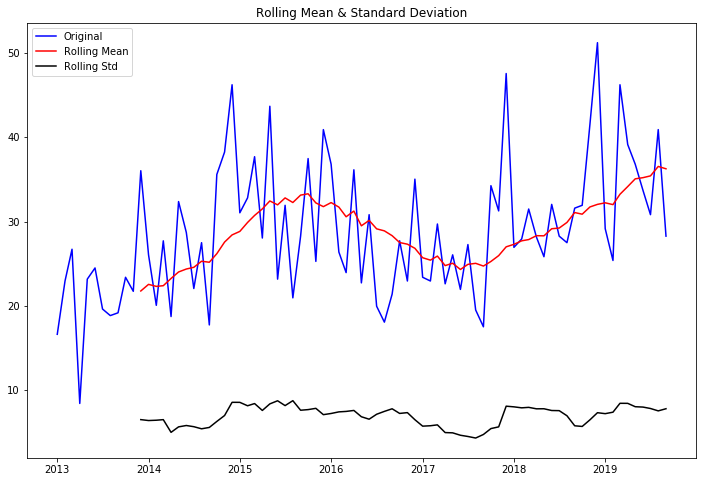

Results of Dickey-Fuller Test:
p-value = 0.1044. The series is likely non-stationary.
Test Statistic                 -2.547032
p-value                         0.104446
#Lags Used                     15.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [127]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(dataTrain['9L Cases'])


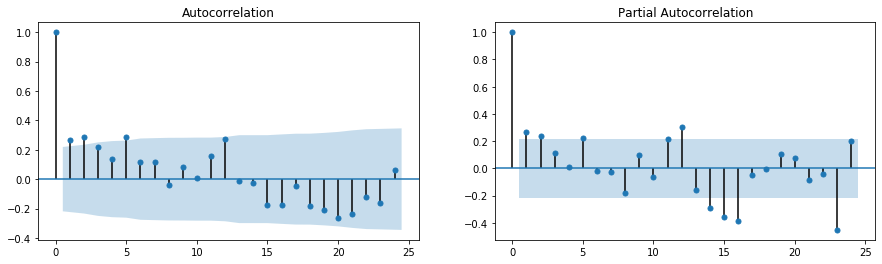

In [133]:
# Graph data
#https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(dataTrain.iloc[1:]['9L Cases'], lags=24, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(dataTrain.iloc[1:]['9L Cases'], lags=24, ax=axes[1])



In [160]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endogTrain, exogTrain, order=(1,1,1),seasonal_order=(0,1,0,12))
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            9L Cases   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -213.243
Date:                             Sat, 27 Jun 2020   AIC                            444.486
Time:                                     21:02:37   BIC                            464.461
Sample:                                 01-01-2013   HQIC                           452.401
                                      - 09-01-2019                                         
Covariance Type:                               opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Dollar Sales per 9L Case     0.0031      0.001      4.397      0.000       0.0

### Prediction

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html


In [161]:
res.predict(dynamic=False,steps=1,start='2017-01-01')[0:3]

Month
2017-01-01    30.345998
2017-02-01    24.474153
2017-03-01    26.382977
Freq: MS, dtype: float64

In [162]:
res.get_prediction(start='2017-01-01',dynamic=True, full_results=True).summary_frame()[0:3]

9L Cases,mean,mean_se,mean_ci_lower,mean_ci_upper
Month,,,,
2017-01-01,30.345998,6.125567,18.340108,42.351889
2017-02-01,23.896777,6.146614,11.849635,35.943919
2017-03-01,28.033454,6.342611,15.602165,40.464743


### Prediction with Exogenous vars

Creating future set of exog vars
https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [164]:
endogTest = dataTest[colPreds]
exogTest =dataTest[colEndog + colExog ]
endogTest.shape,exogTest.shape
exogTest.head(1)

,Dollar Sales per 9L Case,0,1,2,3,Dollar Sales per 9L Case
Month,,,,,,
2019-10-01,3823.40256,1626.433048,0.0,2018.803448,179.538462,3823.40256


Prediction

In [165]:
#https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
#res.get_prediction(start='2017-05-01',dynamic=True, full_results=True,exog=dataPred).summary_frame()
pred=res.predict(start = '2019-10-01',end='2019-12-01',exog=exogTest)
print(pred)
dataTest

2019-10-01    32.477167
2019-11-01    42.249294
2019-12-01    55.762753
Freq: MS, dtype: float64


,Month,Product,9L Cases,Dollar Sales per 9L Case,0,1,2,3
Month,,,,,,,,
2019-10-01,2019-10-01,JACK DANIELS BLK WHSKY 1L,36.687,3823.402560,1626.433048,0.000000,2018.803448,179.538462
2019-11-01,2019-11-01,JACK DANIELS BLK WHSKY 1L,40.011,4302.033466,1768.153846,217.984962,0.000000,0.000000
2019-12-01,2019-12-01,JACK DANIELS BLK WHSKY 1L,44.112,4063.029034,3333.435897,0.000000,0.000000,168.256410


In [167]:
res.get_forecast(3,exog=exogTest).summary_frame()

9L Cases,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-10-01,32.477167,6.125567,20.471277,44.483057
2019-11-01,42.249294,6.146614,30.202151,54.296436
2019-12-01,55.762753,6.342611,43.331464,68.194043


In [168]:
res.get_prediction(start = '2019-10-01',end='2019-12-01',exog=exogTest).summary_frame()

9L Cases,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-10-01,32.477167,6.125567,20.471277,44.483057
2019-11-01,42.249294,6.146614,30.202151,54.296436
2019-12-01,55.762753,6.342611,43.331464,68.194043


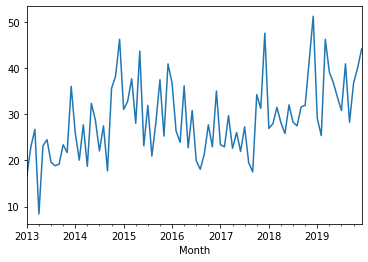

In [169]:
data['9L Cases'].plot()

## VAR

### Model

In [376]:
#variables
endog = data[colPreds + colEndog] #here we move the Endog with then col Prds.. this is different than SARIMAX
exog =data[colExog ]
#allVars = data[colPreds + colEndog +- colExog]
display(endog.head(3))
display(exog.head(3))
#display(allVars.head(3))


,9L Cases,Dollar Sales per 9L Case
Month,,
2013-01-01,19.89,234.914530
2013-02-01,16.38,140.948718
2013-03-01,22.23,187.931624


,TAAKA VODKA 80 PET 1.75L,TAAKA VODKA 80 BLUE PET 375M,TAAKA VODKA 80 BLUE PET 200M,TAAKA CAKE VODKA PET 1.75L,DOBRA VODKA PET 375M
Month,,,,,
2013-01-01,234.914530,0.00,0.0,0.0,196.578095
2013-02-01,140.948718,58.56,0.0,0.0,0.000000
2013-03-01,187.931624,0.00,0.0,0.0,65.670000


In [377]:
# Fit the model
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR
# https://github.com/statsmodels/statsmodels/issues/6636
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model = VAR( endog, exog)
res=model.select_order(15) #select best AIC/BIC.. we can do a ggrid search here
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -54.73      -54.35   1.698e-24      -54.58
1       -53.66      -53.14   4.988e-24      -53.45
2      -55.30*     -54.65*  9.693e-25*     -55.04*
3       -54.18      -53.40   2.979e-24      -53.87
4       -47.86      -46.95   1.660e-21      -47.50
5       -49.29      -48.26   3.981e-22      -48.88
6       -50.16      -48.99   1.688e-22      -49.70
7       -51.90      -50.60   2.994e-23      -51.38
8       -51.56      -50.13   4.253e-23      -50.99
9       -52.37      -50.82   1.915e-23      -51.75
10      -52.99      -51.30   1.052e-23      -52.32
11      -52.37      -50.55   1.999e-23      -51.65
12      -50.51      -48.57   1.313e-22      -49.74
13      -47.98      -45.91   1.699e-21      -47.16
14      -51.15      -48.95   7.375e-23      -50.28
15      -50.19      -47.86   2.000e-22      -49.27
-------------------------------

In [378]:
fit= model.fit(maxlags=2)
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 21, Jun, 2020
Time:                     10:05:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -54.2820
Nobs:                     82.0000    HQIC:                  -54.6333
Log likelihood:           2036.92    FPE:                1.48513e-24
AIC:                     -54.8690    Det(Omega_mle):     1.17982e-24
--------------------------------------------------------------------
Results for equation 9L Cases
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               18.427147         5.418488            3.401           0.001
TAAKA VODKA 80 PET 1.75L             0.047178         0.013247            3.561           0.0

### Prediction

In [358]:

forecastPeriods = 5
dfPred= pd.DataFrame({'Month' : pd.date_range('2020-01-01',periods = forecastPeriods,freq='MS')})
cols= colPreds + colExog + colEndog
for i,c in enumerate(cols):
    dfPred[c] = data[c][-1] 
    dfPred[c]  = dfPred[c] ** (1+dfPred.index/500)

dfPred.set_index(colTime,inplace=True)
dfPred=dfPred.asfreq(freq=pd.offsets.MonthBegin())

dfPredEndog = dfPred[colEndog]
dfPredExog = dfPred[colExog]

lag_order = fit.k_ar
dfPredEndog = endog[-lag_order:].append(dfPredEndog)
dfPredEndog = endog[-lag_order:]
dfPredExog = exog.append(dfPredExog)[-forecastPeriods:]

display(dfPredEndog,dfPredExog)

,9L Cases,Dollar Sales per 9L Case
Month,,
2019-11-01,41.73,417.538462
2019-12-01,45.63,464.564103


,TAAKA VODKA 80 PET 1.75L,TAAKA VODKA 80 BLUE PET 375M,TAAKA VODKA 80 BLUE PET 200M,TAAKA CAKE VODKA PET 1.75L,DOBRA VODKA PET 375M
Month,,,,,
2020-01-01,464.564103,755.523189,188.411215,0.0,0.0
2020-02-01,470.305156,765.604177,190.395624,0.0,0.0
2020-03-01,476.117156,775.819676,192.400934,0.0,0.0
2020-04-01,482.000981,786.171481,194.427365,0.0,0.0
2020-05-01,487.957518,796.661411,196.475139,0.0,0.0


In [379]:
pred = fit.forecast(y=dfPredEndog.values,exog_future =dfPredExog.values, steps=forecastPeriods)
pred

array([[ 43.09146742, 464.56410256],
       [ 44.47615655, 470.30515558],
       [ 44.14897038, 476.11715615],
       [ 44.7343172 , 482.00098105],
       [ 44.90929094, 487.95751787]])

## VARMAX

### Model

In [361]:
#variables
# VARMAX https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html
# VARMAC https://mc.ai/11-classical-time-series-forecasting-methods-in-python-cheat-sheet/

endog = data[colPreds] #here we move the Endog with then col Prds.. this is different than SARIMAX
exog =data[colExog + colEndog]
allVars = data[colPreds + colEndog + colExog]
display(endog.head(3))
display(exog.head(3))
display(allVars.head(3))


,9L Cases
Month,
2013-01-01,19.89
2013-02-01,16.38
2013-03-01,22.23


,TAAKA VODKA 80 PET 1.75L,TAAKA VODKA 80 BLUE PET 375M,TAAKA VODKA 80 BLUE PET 200M,TAAKA CAKE VODKA PET 1.75L,DOBRA VODKA PET 375M,Dollar Sales per 9L Case
Month,,,,,,
2013-01-01,234.914530,0.00,0.0,0.0,196.578095,234.914530
2013-02-01,140.948718,58.56,0.0,0.0,0.000000,140.948718
2013-03-01,187.931624,0.00,0.0,0.0,65.670000,187.931624


,9L Cases,Dollar Sales per 9L Case,TAAKA VODKA 80 PET 1.75L,TAAKA VODKA 80 BLUE PET 375M,TAAKA VODKA 80 BLUE PET 200M,TAAKA CAKE VODKA PET 1.75L,DOBRA VODKA PET 375M
Month,,,,,,,
2013-01-01,19.89,234.914530,234.914530,0.00,0.0,0.0,196.578095
2013-02-01,16.38,140.948718,140.948718,58.56,0.0,0.0,0.000000
2013-03-01,22.23,187.931624,187.931624,0.00,0.0,0.0,65.670000


In [365]:
# Fit the model
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR
# VARMAX https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html
# VARMAC https://mc.ai/11-classical-time-series-forecasting-methods-in-python-cheat-sheet/
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX
model = VARMAX( endog, exog=exog,order=(0,1),trend='n')
#res=model.select_order(15) #select best AIC/BIC.. we can do a ggrid search here
#print(res.summary())

In [366]:
fit= model.fit(maxiter=1000)
fit.summary()

ValueError: Only gave one variable to VAR

### Prediction

In [358]:

forecastPeriods = 5
dfPred= pd.DataFrame({'Month' : pd.date_range('2020-01-01',periods = forecastPeriods,freq='MS')})
cols= colPreds + colExog + colEndog
for i,c in enumerate(cols):
    dfPred[c] = data[c][-1] 
    dfPred[c]  = dfPred[c] ** (1+dfPred.index/500)

dfPred.set_index(colTime,inplace=True)
dfPred=dfPred.asfreq(freq=pd.offsets.MonthBegin())

dfPredEndog = dfPred[colEndog]
dfPredExog = dfPred[colExog]

lag_order = fit.k_ar
dfPredEndog = endog[-lag_order:].append(dfPredEndog)
dfPredEndog = endog[-lag_order:]
dfPredExog = exog.append(dfPredExog)[-forecastPeriods:]

display(dfPredEndog,dfPredExog)

,9L Cases,Dollar Sales per 9L Case
Month,,
2019-11-01,41.73,417.538462
2019-12-01,45.63,464.564103


,TAAKA VODKA 80 PET 1.75L,TAAKA VODKA 80 BLUE PET 375M,TAAKA VODKA 80 BLUE PET 200M,TAAKA CAKE VODKA PET 1.75L,DOBRA VODKA PET 375M
Month,,,,,
2020-01-01,464.564103,755.523189,188.411215,0.0,0.0
2020-02-01,470.305156,765.604177,190.395624,0.0,0.0
2020-03-01,476.117156,775.819676,192.400934,0.0,0.0
2020-04-01,482.000981,786.171481,194.427365,0.0,0.0
2020-05-01,487.957518,796.661411,196.475139,0.0,0.0


In [359]:
pred = fit.forecast(y=dfPredEndog.values,exog_future =dfPredExog.values, steps=forecastPeriods)
pred

array([[ 43.09146742, 464.56410256],
       [ 44.47615655, 470.30515558],
       [ 44.14897038, 476.11715615],
       [ 44.7343172 , 482.00098105],
       [ 44.90929094, 487.95751787]])